<a href="https://colab.research.google.com/github/donuva/geo-cluster2/blob/main/GEO_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fiona

In [ ]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import pandas
import pulp
import shapely
from shapely.geometry import Point
import spopt
import time
import warnings
import fiona


In [ ]:
network_distance = pandas.read_csv( "/content/sample_data/network_distance.csv")
demand_points = pandas.read_csv( "/content/sample_data/demand-point.csv" , index_col=0)
facility_points = pandas.read_csv("/content/sample_data/store_geo.csv", index_col=0)
facility_points = facility_points.reset_index(drop=True)
demand_points = demand_points.reset_index(drop=True)


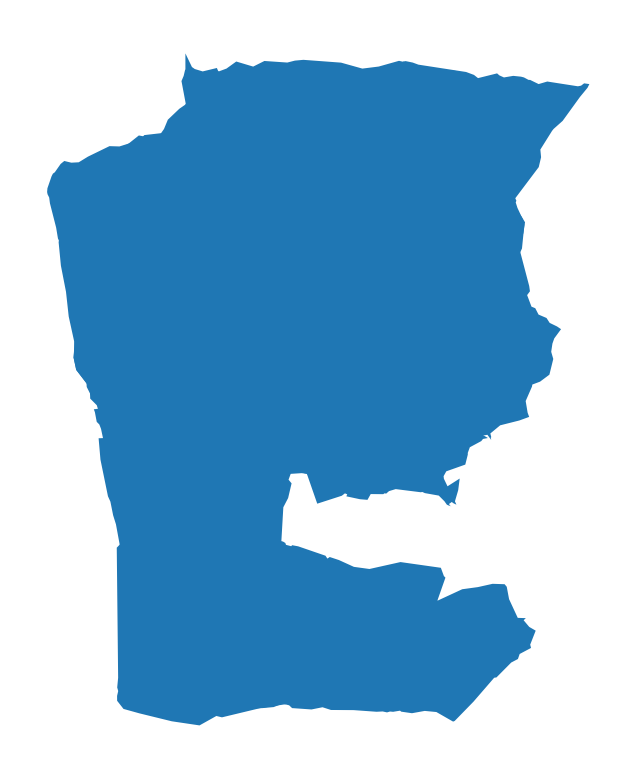

In [ ]:
from osgeo import gdal
import geopandas as gpd
gdal.SetConfigOption('SHAPE_RESTORE_SHX', 'YES')
in_vector = '/content/sample_data/shapefile/service.shp'
study_area = gpd.read_file(in_vector)

base = study_area.plot()
base.axis("off");

In [ ]:
ntw_dist_piv = network_distance.pivot_table(
    values="distance", index="DestinationName", columns="name"
)

cost_matrix = ntw_dist_piv.to_numpy()
n_dem_pnts = demand_points.shape[0]
n_fac_pnts = facility_points.shape[0]
process = lambda df: as_gdf(df).sort_values(by=["NAME"]).reset_index(drop=True)
as_gdf = lambda df: geopandas.GeoDataFrame(df, geometry=pnts(df))
pnts = lambda df: geopandas.points_from_xy(df.long, df.lat)
facility_points = process(facility_points)
demand_points = process(demand_points)

In [ ]:
for _df in [facility_points, demand_points, study_area]:
    _df.set_crs("EPSG:4326", inplace=True)
    _df.to_crs("EPSG:7131", inplace=True)

In [ ]:
ai = demand_points["POP2000"].to_numpy()

# maximum service radius (in meters)
SERVICE_RADIUS = 5000

# number of candidate facilities in optimal solution
P_FACILITIES = 4

In [ ]:
dv_colors_arr = [
    "darkcyan",
    "mediumseagreen",
    "saddlebrown",
    "darkslategray",
    "lightskyblue",
    "thistle",
    "lavender",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "cyan",
    "limegreen",
    "mediumorchid",
]
dv_colors = {f"y{i}": dv_colors_arr[i] for i in range(len(dv_colors_arr))}
dv_colors

{'y0': 'darkcyan',
 'y1': 'mediumseagreen',
 'y2': 'saddlebrown',
 'y3': 'darkslategray',
 'y4': 'lightskyblue',
 'y5': 'thistle',
 'y6': 'lavender',
 'y7': 'darkgoldenrod',
 'y8': 'peachpuff',
 'y9': 'coral',
 'y10': 'mediumvioletred',
 'y11': 'blueviolet',
 'y12': 'fuchsia',
 'y13': 'cyan',
 'y14': 'limegreen',
 'y15': 'mediumorchid'}

In [ ]:
def plot_results(model, p, facs, clis=None, ax=None):
    """Visualize optimal solution sets and context."""
    if not ax:
        multi_plot = False
        fig, ax = plt.subplots(figsize=(6, 9))
        markersize, markersize_factor = 4, 4
    else:
        ax.axis("off")
        multi_plot = True
        markersize, markersize_factor = 2, 2
    ax.set_title(model.name, fontsize=15)

    # extract facility-client relationships for plotting (except for p-dispersion)
    plot_clis = isinstance(clis, geopandas.GeoDataFrame)
    if plot_clis:
        cli_points = {}
    fac_sites = {}
    for i, dv in enumerate(model.fac_vars):
        if dv.varValue:
            dv, predef = facs.loc[i, ["dv", "predefined_loc"]]
            fac_sites[dv] = [i, predef]
            if plot_clis:
                geom = clis.iloc[model.fac2cli[i]]["geometry"]
                cli_points[dv] = geom

    # study area and legend entries initialization
    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)
    _patch = Patch(alpha=0.5, fc="tan", ec="k", label="Dissolved Service Areas")
    legend_elements = [_patch]

    if plot_clis:
        # any clients that not asscociated with a facility
        if model.name.startswith("mclp"):
            c = "k"
            if model.n_cli_uncov:
                idx = [i for i, v in enumerate(model.cli2fac) if len(v) == 0]
                pnt_kws = dict(ax=ax, fc=c, ec=c, marker="s", markersize=7, zorder=2)
                clis.iloc[idx].plot(**pnt_kws)
            _label = f"Demand sites not covered ($n$={model.n_cli_uncov})"
            _mkws = dict(marker="s", markerfacecolor=c, markeredgecolor=c, linewidth=0)
            legend_elements.append(mlines.Line2D([], [], ms=3, label=_label, **_mkws))

    # all candidate facilities
    facs.plot(ax=ax, fc="brown", marker="*", markersize=80, zorder=8)
    _label = f"Facility sites ($n$={len(model.fac_vars)})"
    _mkws = dict(marker="*", markerfacecolor="brown", markeredgecolor="brown")
    legend_elements.append(mlines.Line2D([], [], ms=7, lw=0, label=_label, **_mkws))

    # facility-(client) symbology and legend entries
    zorder = 4
    for fname, (fac, predef) in fac_sites.items():
        cset = dv_colors[fname]
        if plot_clis:
            # clients
            geoms = cli_points[fname]
            gdf = geopandas.GeoDataFrame(geoms)
            gdf.plot(ax=ax, zorder=zorder, ec="k", fc=cset, markersize=100 * markersize)
            _label = f"Demand sites covered by {fname}"
            _mkws = dict(markerfacecolor=cset, markeredgecolor="k", ms=markersize + 7)
            legend_elements.append(
                mlines.Line2D([], [], marker="o", lw=0, label=_label, **_mkws)
            )
        # facilities
        ec = "k"
        lw = 2
        predef_label = "predefined"
        if model.name.endswith(predef_label) and predef:
            ec = "r"
            lw = 3
            fname += f" ({predef_label})"
        facs.iloc[[fac]].plot(
            ax=ax, marker="*", markersize=1000, zorder=9, fc=cset, ec=ec, lw=lw
        )
        _mkws = dict(markerfacecolor=cset, markeredgecolor=ec, markeredgewidth=lw)
        legend_elements.append(
            mlines.Line2D([], [], marker="*", ms=20, lw=0, label=fname, **_mkws)
        )
        # increment zorder up and markersize down for stacked client symbology
        zorder += 1
        if plot_clis:
            markersize -= markersize_factor / p

    if not multi_plot:
        # legend
        kws = dict(loc="upper left", bbox_to_anchor=(1.05, 0.7))
        plt.legend(handles=legend_elements, **kws)

In [ ]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 121654 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

In [ ]:
from spopt.locate import LSCP
lscp = LSCP.from_cost_matrix(cost_matrix, SERVICE_RADIUS)
lscp = lscp.solve(pulp.GLPK(msg=False))
lscp_objval = lscp.problem.objective.value()
lscp_objval

8

In [ ]:
facility_points["dv"] = lscp.fac_vars
facility_points["dv"] = facility_points["dv"].map(lambda x: x.name.replace("_", ""))
facility_points["predefined_loc"] = 0


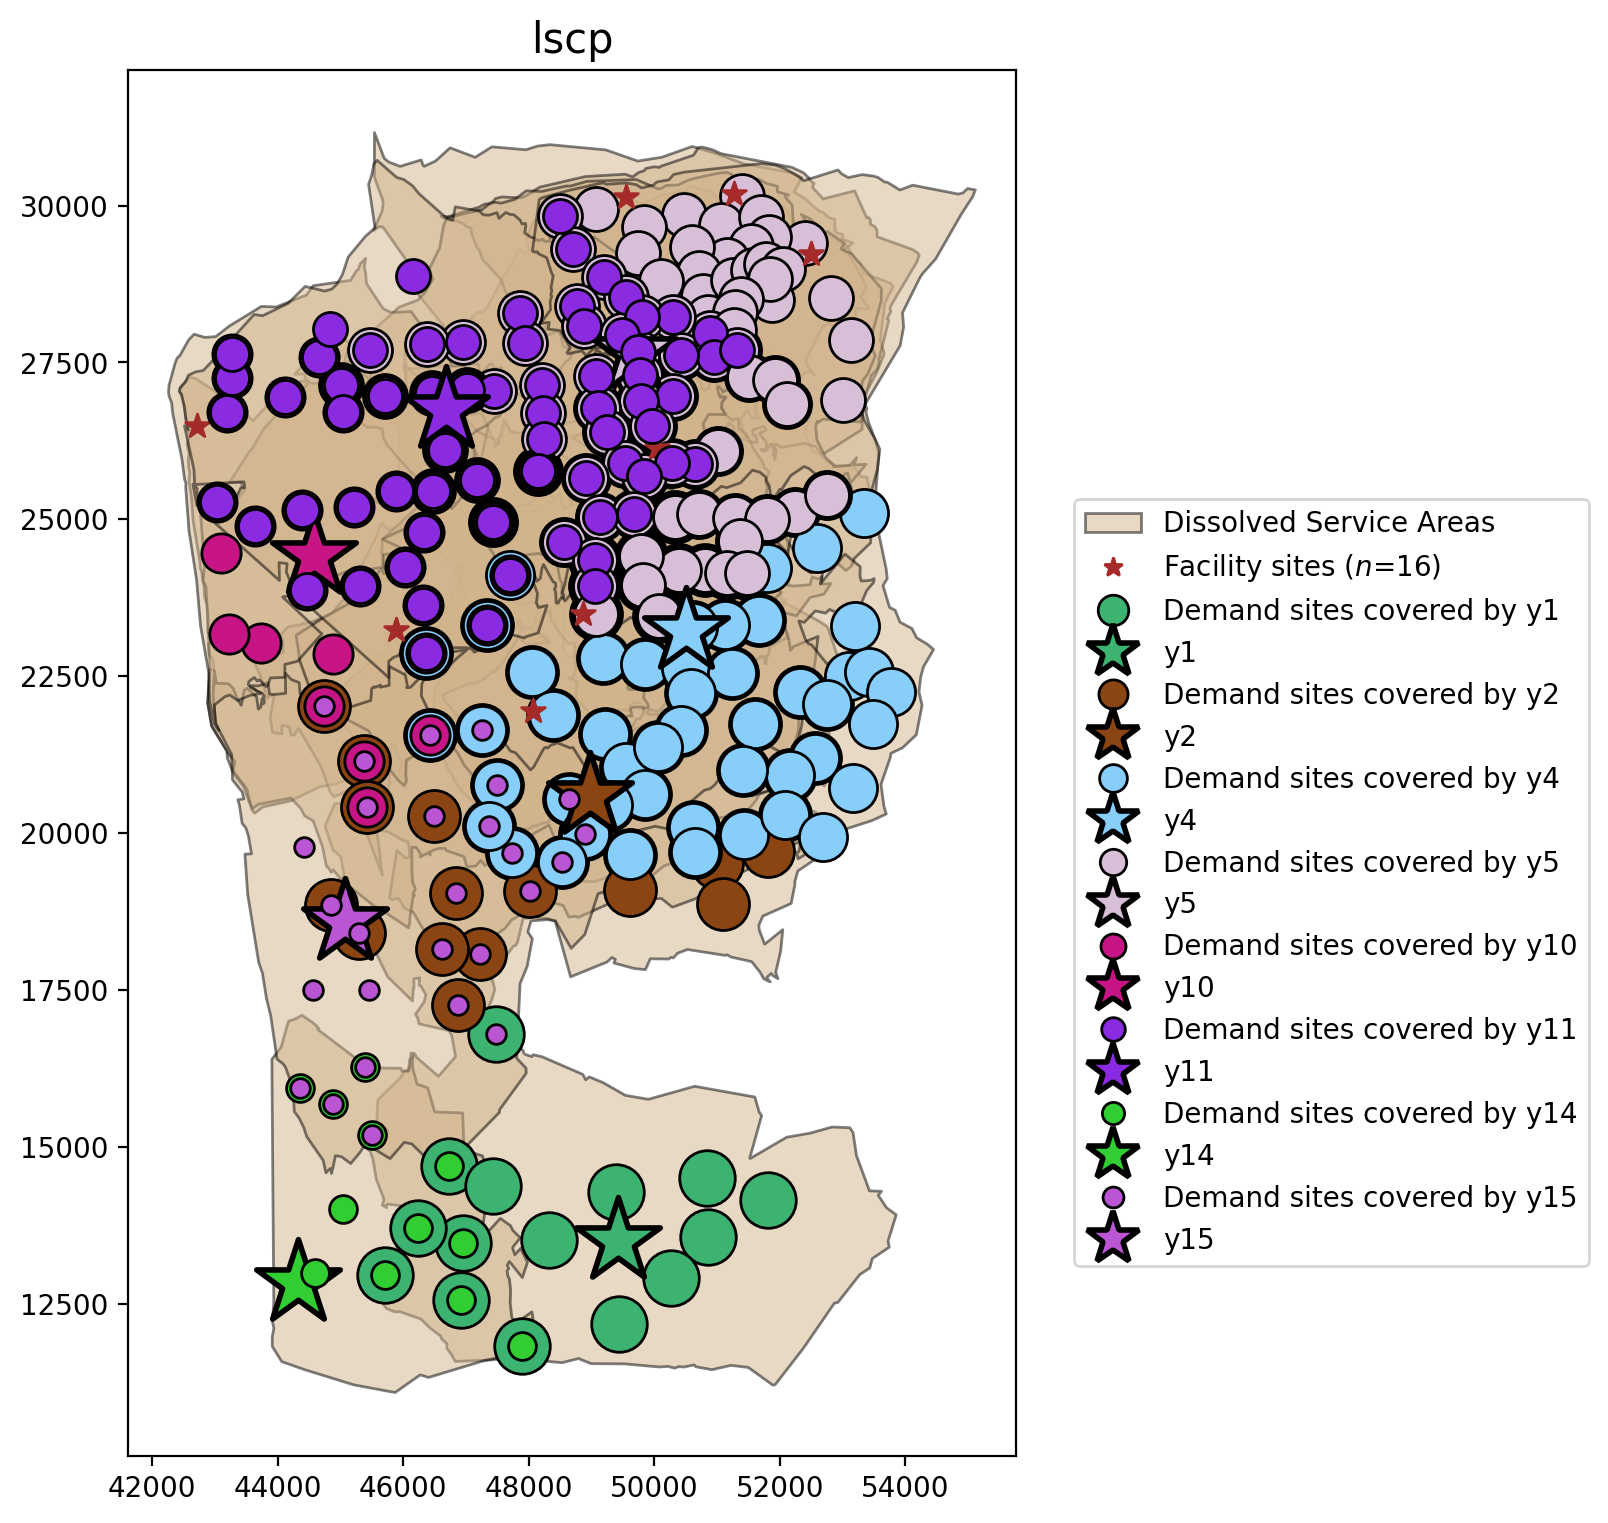

In [ ]:
plot_results(lscp, lscp_objval, facility_points, clis=demand_points)

In [ ]:
from spopt.locate import PMedian
pmedian = PMedian.from_cost_matrix(cost_matrix, ai, p_facilities=P_FACILITIES)
pmedian = pmedian.solve(pulp.GLPK(msg=False))
pmedian.problem.objective.value()
pmedian.mean_dist

2982.1268579890657

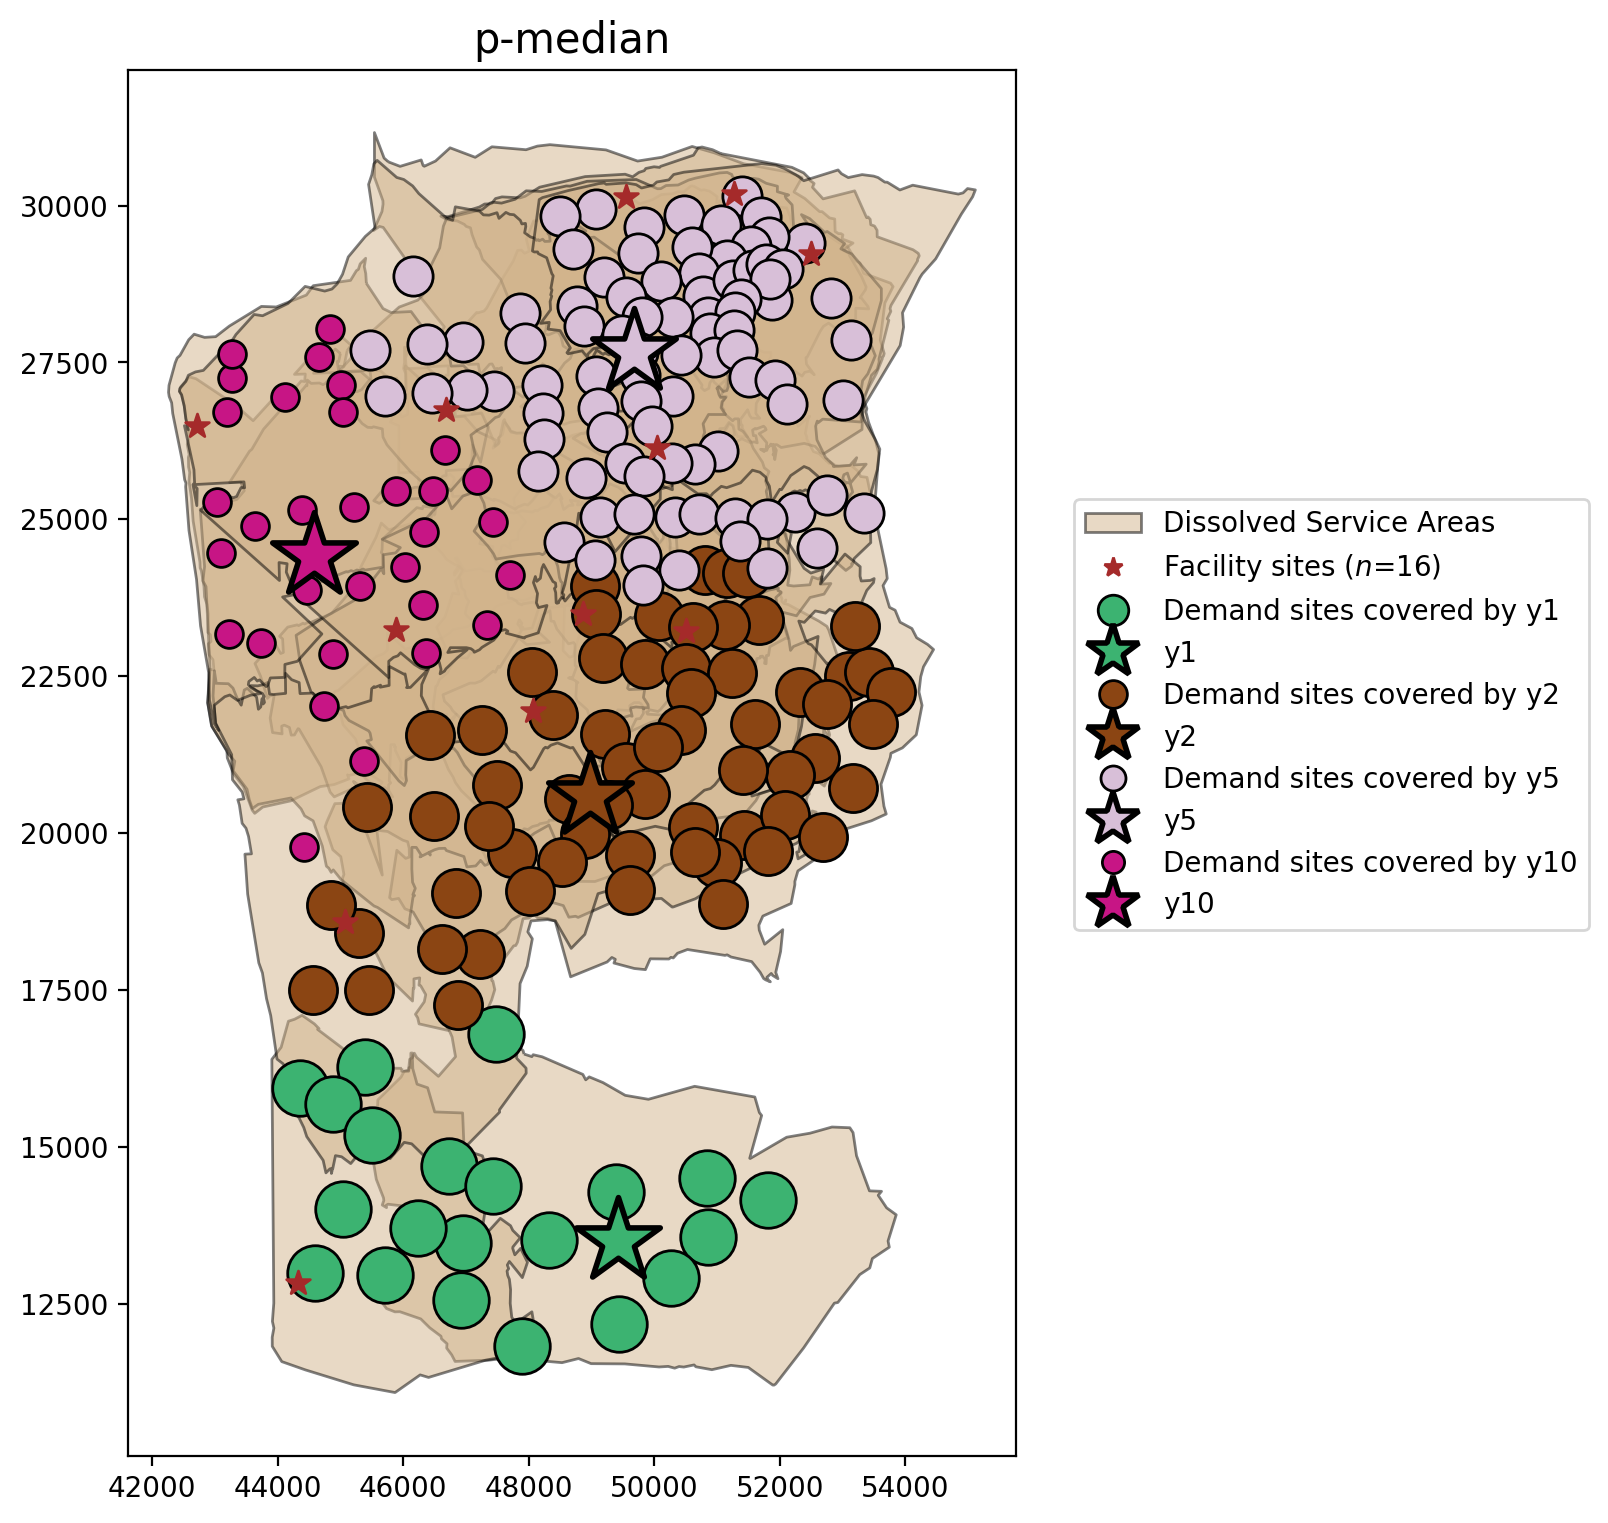

In [ ]:
plot_results(pmedian, P_FACILITIES, facility_points, clis=demand_points)